# CAP 5415 Term Project

#### By Daniel Silva

This notebook allows you to test my detection and classification models on a handful of images

In [36]:
import torch
from torchvision import transforms

import matplotlib.pyplot as plt
import os 
import random
from itertools import combinations
import PIL.Image as pil 
import cv2

from my_utils import *

In [4]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

These are the paths we'll need

In [5]:
data_path = 'SVHN_dataset/data/'
model_path = 'models'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Loading in the best model I trained

In [8]:
model_name = 'best_model.tar'
model, optimizer, criterion, epoch, device = load_model(os.path.join(model_path, model_name))
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform()
  (backbone): DigitModel(
    (block1): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (block2): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (block3): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (bl

The following functions will be needed to post process and display the predictions

In [9]:
def order_preds(labels, bboxs):
    '''Orders predictions from left to right, based on their bounding box location'''
    
    if len(labels) < 2:
        return labels
    
    ordered = [x.item() for _,x in sorted(zip(bboxs[:, 2], labels))]
        
    return torch.tensor(ordered)

In [10]:
def IoU(gt_box, pred_box):
    '''Calculates the Intersection over Union score of two bounding boxes'''
    
    # Determine the coordinates of the intersection rectangle
    x1 = max(gt_box[0], pred_box[0])
    y1 = max(gt_box[1], pred_box[1])
    x2 = min(gt_box[2], pred_box[2])
    y2 = min(gt_box[3], pred_box[3])

    # Compute the area of intersection rectangle
    inter_area = max(0, x2 - x1 + 1) * max(0, y2 - y1 + 1)

    # Compute the area of both the prediction and ground-truth rectangles
    gt_area = (gt_box[2] - gt_box[0] + 1) * (gt_box[3] - gt_box[1] + 1)
    pred_area = (pred_box[2] - pred_box[0] + 1) * (pred_box[3] - pred_box[1] + 1)

    # Compute the intersection over union 
    # This is the intersection area divided by (prediction + ground-truth - the interesection area)
    iou = inter_area / float(gt_area + pred_area - inter_area)

    # return the intersection over union value
    return iou

In [11]:
def post_process(pred):
    '''Remove redundant bounding boxes and their associated labels, then orders labels from left to right'''
    
    # If zero or one bbox's are predicted, no need to process anything, simply return original predictions
    if len(pred['labels']) < 2:
        return pred['labels'], pred['boxes'], pred['labels']
    
    # Calculate the IoU score for each pair of predicted bounding boxes
    IoUs = {(i,j): IoU(pred['boxes'][i], pred['boxes'][j])\
            for i,j in list(combinations(range(len(pred['labels'])), 2))}

    # Find the redundant bounding boxes
    # If a pair is found to be redundant, we'll remove the bbox with the lower confidence score
    redundant = []
    for i in IoUs.keys():
        if IoUs[i] > 0.4:
            redundant.append(i[1])
    
    # Create a new list of labels and bounding boxes without those found to be reduntant
    new_labels = []
    new_boxes = []
    for i in range(len(pred['labels'])):
        if i not in redundant:
            new_labels.append(pred['labels'][i].item())
            new_boxes.append(pred['boxes'][i].tolist()) 
            
    new_boxes = torch.tensor(new_boxes)
    new_labels = torch.tensor(new_labels)
    
    # Order the new labels from left to right, based on positioning of associated bounding boxes
    ordered_labels = order_preds(new_labels, new_boxes)
    
    return new_labels, new_boxes, ordered_labels

In [12]:
def draw_bbox(img, labels, bboxes):
    '''Draws the bounding boxes associated with an image'''
    
    image = cv2.cvtColor(img.mul(255).permute(1, 2, 0).byte().numpy(), cv2.COLOR_BGR2RGB)
    for j in range(len(labels)):
        x1, y1, x2, y2 = bboxes[j][0], bboxes[j][1],\
                            bboxes[j][2], bboxes[j][3]
        cv2.rectangle(image, (x1, y1), (x2, y2), (0,0,255), 1)
        #cv2.putText(image, str(labels[j].item()), (x1 + 1, y1 + 9), cv2.LINE_AA, 0.4, (255, 0, 0))
        
    return image

This function enables you to run the model on the set of test images and display the results

In [54]:
def test_model(model, test_files):
    '''Test a faster rcnn model on a given number of images'''
    fig = plt.figure(len(test_files), (12,12))
    
    # Loop through each test file, there are 10
    for i, file in enumerate(test_files):
        ax = plt.subplot(len(test_files) // 2, 2, i+1)
        
        # Load image
        img = transforms.Compose([transforms.ToTensor()])(pil.open(file))
        
        # Get prediction
        with torch.no_grad():
            pred = model([img.to(device)])[0]
        
        # Remove redundant bounding boxes and order labels from left to right
        labels, bboxes, ordered_preds = post_process(pred)
        
        # Draw predicted boxes and display image
        image = draw_bbox(img, labels, bboxes)
        label = ''.join([str(i.item()) if i.item() != 10 else str(0) for i in ordered_preds])
        ax.set_title('Prediction: ' + label, fontsize=20)
        ax.axis('off')
        ax.imshow(image)

Getting the list of files

In [55]:
test_files = [os.path.join(os.getcwd(), data_path, i) for i in os.listdir(data_path)]

Testing!

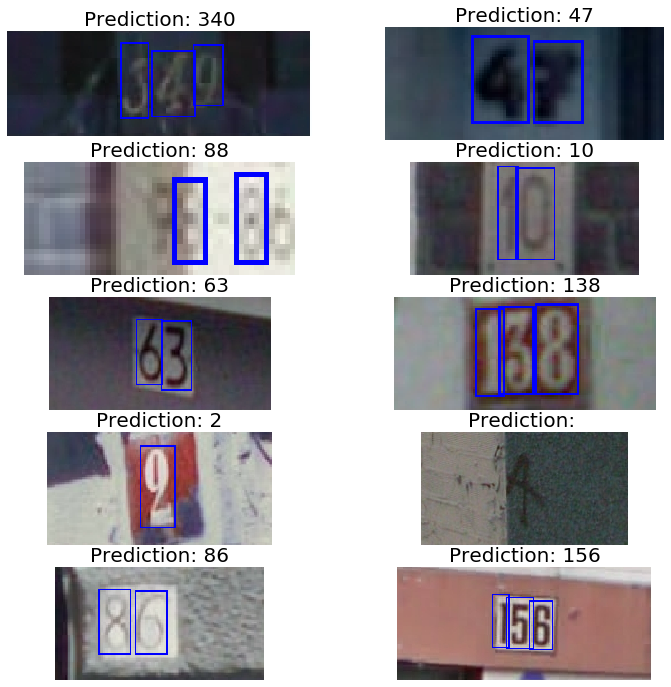

In [56]:
test_model(model, test_files)